In [160]:
#import midi_functions
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import callbacks

#import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [69]:
#dont use this section
song = './Bach-1.mid'
features = midi_functions.get_features(path=song)

input_length = 10 #How many past notes we want to give the LSTM to predict the next one
X, Y = midi_functions.get_XY(features,n_notes=input_length)
X = X[:,np.arange(0,4 * input_length,4)]#gets only the notes and discards velocity/time info
Y = Y[:,0]

#How many notes are present?
sorted_notes = np.copy(Y)
sorted_notes.sort()
sorted_notes = np.unique(sorted_notes)

number_of_different_notes = len(sorted_notes)
print('Number of different notes: {}'.format(number_of_different_notes))

#Convert Y into the one-hot-representation because I think that is the only thing that works with softmax representation
for i,note in enumerate(Y): #make all the notes a number between 0 and number_of_different_notes
    Y[i] = np.where(sorted_notes == note)[0]
Y = np_utils.to_categorical(Y)
print(Y.shape)


Number of different notes: 38
(699, 38)


In [37]:
#Dont use this section
#randomize the two arrays and split into training and validation
n = len(X)
permutation = np.random.permutation(n)
X = X[permutation]
Y = Y[permutation]

X_val = X[:200]
Y_val = Y[:200]
X_train = X[200:]
Y_train = Y[200:]

In [120]:
X = np.loadtxt('X.txt')
Y = np.loadtxt('Y.txt')

n = len(X)
permutation = np.random.permutation(n)
X = X[permutation]
Y = Y[permutation]

sorted_notes = np.copy(Y)
sorted_notes.sort()
sorted_notes = np.unique(sorted_notes)

number_of_different_notes = len(sorted_notes)
print('Number of different notes: {}'.format(number_of_different_notes))

for i,note in enumerate(Y): #make all the notes a number between 0 and number_of_different_notes
    Y[i] = np.where(sorted_notes == note)[0]
Y = np_utils.to_categorical(Y)
print(X.shape)

#X_val = X[:1000]
#Y_val = Y[:1000]
#X_train = X[1000:]
#Y_train = Y[1000:]
#print(X_train.shape)

Number of different notes: 67
(9976, 10)


In [122]:
input_length = 10
#input_dimensions = (input_length,1)

n_hidden_units = number_of_different_notes #this should probably be the number of different notes since it is also the output of softmax

model = Sequential()
model.add(LSTM(
    n_hidden_units,
    input_shape=((input_length,1)),
    return_sequences=True
))
model.add(LSTM(n_hidden_units, return_sequences=False))
#model.add(Dropout(0.3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# Load the weights to each node
#model.load_weights('weights.hdf5')


#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model.summary())
#print(model.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 10, 67)            18492     
_________________________________________________________________
lstm_28 (LSTM)               (None, 67)                36180     
_________________________________________________________________
activation_15 (Activation)   (None, 67)                0         
Total params: 54,672
Trainable params: 54,672
Non-trainable params: 0
_________________________________________________________________
None


In [162]:
class live_plot(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.index = 0
        self.epochs = []
        
        self.losses = []
        self.val_losses = []
        
        self.acc = []
        self.val_acc = []
        
        #self.figure = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.epochs.append(self.index)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs['val_acc'])
        self.index += 1
        
        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

In [152]:
filepath = "./weights/2LSTM-{epoch:02d}-{loss:.4f}.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

plot = live_plot()

callbacks_list = [checkpoint, plot]     
fit_data = model.fit(X.reshape(9976, 10,1), Y, validation_split=0.20,epochs=100, batch_size=64, callbacks=callbacks_list)

Train on 7980 samples, validate on 1996 samples
Epoch 1/100
7980/7980 [==============================] - 2s 255us/step - loss: 2.7715 - acc: 0.4284 - val_loss: 3.1647 - val_acc: 0.2806
Epoch 2/100
7980/7980 [==============================] - 2s 253us/step - loss: 2.7728 - acc: 0.4248 - val_loss: 3.1870 - val_acc: 0.2856
Epoch 3/100
7980/7980 [==============================] - 2s 253us/step - loss: 2.7713 - acc: 0.4299 - val_loss: 3.1583 - val_acc: 0.2981
Epoch 4/100
7980/7980 [==============================] - 2s 253us/step - loss: 2.7776 - acc: 0.4272 - val_loss: 3.1529 - val_acc: 0.2996
Epoch 5/100
7980/7980 [==============================] - 2s 254us/step - loss: 2.7705 - acc: 0.4261 - val_loss: 3.1780 - val_acc: 0.2740
Epoch 6/100
7980/7980 [==============================] - 2s 254us/step - loss: 2.7766 - acc: 0.4213 - val_loss: 3.1505 - val_acc: 0.2991
Epoch 7/100
7980/7980 [==============================] - 2s 255us/step - loss: 2.7743 - acc: 0.4254 - val_loss: 3.1816 - val_acc: 

7980/7980 [==============================] - 2s 283us/step - loss: 2.7732 - acc: 0.4279 - val_loss: 3.1745 - val_acc: 0.2690
Epoch 61/100
7980/7980 [==============================] - 2s 275us/step - loss: 2.7686 - acc: 0.4276 - val_loss: 3.1631 - val_acc: 0.3011
Epoch 62/100
7980/7980 [==============================] - 2s 273us/step - loss: 2.7716 - acc: 0.4249 - val_loss: 3.1809 - val_acc: 0.2695
Epoch 63/100
7980/7980 [==============================] - 2s 272us/step - loss: 2.7790 - acc: 0.4194 - val_loss: 3.1693 - val_acc: 0.2931
Epoch 64/100
7980/7980 [==============================] - 2s 267us/step - loss: 2.7703 - acc: 0.4212 - val_loss: 3.1716 - val_acc: 0.2811
Epoch 65/100
7980/7980 [==============================] - 2s 264us/step - loss: 2.7762 - acc: 0.4254 - val_loss: 3.1561 - val_acc: 0.3016
Epoch 66/100
7980/7980 [==============================] - 2s 270us/step - loss: 2.7728 - acc: 0.4259 - val_loss: 3.1615 - val_acc: 0.2991
Epoch 67/100
7980/7980 [=======================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


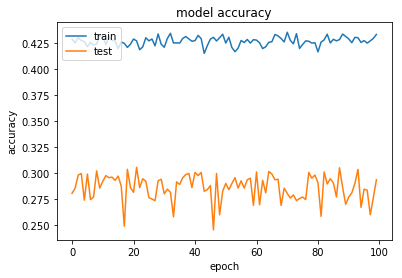

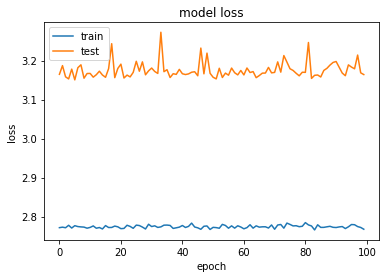

In [155]:
import matplotlib.pyplot as plt

print(fit_data.history.keys())
# summarize history for accuracy
plt.plot(fit_data.history['acc'])
plt.plot(fit_data.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fit_data.history['loss'])
plt.plot(fit_data.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [148]:
#Generate 200 notes

#random sequence to initialize predictions
init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(200 + input_length)
predicted_notes[0:input_length] = init

for note_index in range(200):
    x = predicted_notes[note_index:note_index + input_length]
    #print('Input: {}'.format(x))
    prediction = model.predict(x.reshape(1,10,1))
    #print('Prediction: {}'.format(np.argmax(prediction)))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)]

Input: [56. 71. 72. 53. 73. 72. 61. 71. 72. 52.]
Prediction: 40
Input: [71. 72. 53. 73. 72. 61. 71. 72. 52. 72.]
Prediction: 39
Input: [72. 53. 73. 72. 61. 71. 72. 52. 72. 71.]
Prediction: 39
Input: [53. 73. 72. 61. 71. 72. 52. 72. 71. 71.]
Prediction: 40
Input: [73. 72. 61. 71. 72. 52. 72. 71. 71. 72.]
Prediction: 39
Input: [72. 61. 71. 72. 52. 72. 71. 71. 72. 71.]
Prediction: 40
Input: [61. 71. 72. 52. 72. 71. 71. 72. 71. 72.]
Prediction: 39
Input: [71. 72. 52. 72. 71. 71. 72. 71. 72. 71.]
Prediction: 38
Input: [72. 52. 72. 71. 71. 72. 71. 72. 71. 70.]
Prediction: 37
Input: [52. 72. 71. 71. 72. 71. 72. 71. 70. 69.]
Prediction: 35
Input: [72. 71. 71. 72. 71. 72. 71. 70. 69. 67.]
Prediction: 40
Input: [71. 71. 72. 71. 72. 71. 70. 69. 67. 72.]
Prediction: 37
Input: [71. 72. 71. 72. 71. 70. 69. 67. 72. 69.]
Prediction: 35
Input: [72. 71. 72. 71. 70. 69. 67. 72. 69. 67.]
Prediction: 35
Input: [71. 72. 71. 70. 69. 67. 72. 69. 67. 67.]
Prediction: 35
Input: [72. 71. 70. 69. 67. 72. 69. 67. 

Prediction: 32
Input: [63. 65. 67. 65. 65. 67. 63. 67. 63. 64.]
Prediction: 35
Input: [65. 67. 65. 65. 67. 63. 67. 63. 64. 67.]
Prediction: 31
Input: [67. 65. 65. 67. 63. 67. 63. 64. 67. 63.]
Prediction: 33
Input: [65. 65. 67. 63. 67. 63. 64. 67. 63. 65.]
Prediction: 35
Input: [65. 67. 63. 67. 63. 64. 67. 63. 65. 67.]
Prediction: 33
Input: [67. 63. 67. 63. 64. 67. 63. 65. 67. 65.]
Prediction: 35
Input: [63. 67. 63. 64. 67. 63. 65. 67. 65. 67.]
Prediction: 31
Input: [67. 63. 64. 67. 63. 65. 67. 65. 67. 63.]
Prediction: 31
Input: [63. 64. 67. 63. 65. 67. 65. 67. 63. 63.]
Prediction: 35
Input: [64. 67. 63. 65. 67. 65. 67. 63. 63. 67.]
Prediction: 31
Input: [67. 63. 65. 67. 65. 67. 63. 63. 67. 63.]
Prediction: 35
Input: [63. 65. 67. 65. 67. 63. 63. 67. 63. 67.]
Prediction: 35
Input: [65. 67. 65. 67. 63. 63. 67. 63. 67. 67.]
Prediction: 33
Input: [67. 65. 67. 63. 63. 67. 63. 67. 67. 65.]
Prediction: 35
Input: [65. 67. 63. 63. 67. 63. 67. 67. 65. 67.]
Prediction: 31
Input: [67. 63. 63. 67. 6

In [149]:
predicted_notes

array([56., 71., 72., 53., 73., 72., 61., 71., 72., 52., 72., 71., 71.,
       72., 71., 72., 71., 70., 69., 67., 72., 69., 67., 67., 67., 72.,
       67., 72., 67., 67., 64., 63., 67., 65., 65., 67., 63., 67., 67.,
       65., 67., 63., 65., 67., 63., 65., 63., 65., 67., 63., 64., 67.,
       63., 67., 63., 63., 67., 63., 65., 67., 65., 67., 63., 63., 64.,
       63., 63., 65., 63., 65., 65., 63., 67., 63., 64., 63., 63., 63.,
       63., 63., 65., 65., 62., 63., 63., 64., 67., 67., 64., 67., 63.,
       63., 64., 63., 67., 65., 63., 67., 63., 67., 67., 63., 65., 63.,
       65., 67., 65., 65., 63., 63., 63., 63., 64., 67., 65., 65., 67.,
       63., 67., 64., 64., 67., 63., 65., 67., 65., 67., 63., 63., 67.,
       63., 67., 67., 65., 67., 63., 64., 67., 63., 67., 63., 65., 67.,
       65., 65., 67., 63., 67., 63., 64., 67., 63., 65., 67., 65., 67.,
       63., 63., 67., 63., 67., 67., 65., 67., 63., 64., 67., 63., 67.,
       63., 65., 67., 65., 65., 67., 63., 67., 63., 64., 67., 63